# **Explicit-Implicit Relevance Judgements Correlation Analysis.**


* [Introduction](#Introduction)
* [Loading the ES dataset](#Loading)
* [Strip Plot](#Strip)
* [Interpreting the Correlation Coefficient](#Interpreting)
* [Person versus Spearman](#Pearson)
* [Statistical Power](#Power)

# **Introduction**  <a class="anchor"  id="Introduction"></a>
Learning to Rank (LTR) has traditionally made use of relevance judgements (i.e. human annotations) to create training data for ranking models. But, gathering feedback in the form of relevance judgements is expensive, time-consuming and may be subject to annotator bias. Much research has been carried out by commercial web search providers into harnessing click-through data and using it as a surrogate for relevance judgements. Its use in Enterprise Search (ES), however, has not been explored. If click-through data relevance feedback correlates with that of the human relevance judgements, we could dispense with small relevance judgement training data and rely entirely on abundant quantities of click-through data. 

We performed a correlation analysis and compared the ranking performance of a ‘real world’ ES service of a large organisation using both relevance judgements and click-through data. We introduce and publish the ENTRP-SRCH dataset specifically for ES. 

We calculated a correlation coefficient of ρ = 0.704 (p<0.01). Additionally, the nDCG@3 ranking performance using relevance judgements is just 1.6% higher than when click-through data is used. Subsequently, we discuss ES implementation trade-offs between relevance judgements and implicit feedback and highlight potential preferences and biases of both end-users and expert annotators.

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/explicitimplicitv5/explicit-implicit-v5.csv
/kaggle/input/explicitimplicitv5/explicit-implicit-v6.csv
/kaggle/input/entrp-srch/ENTRP-SRCH-v14.txt
/kaggle/input/entrp-srch/dataset-with-urls.txt


In [2]:
#!pip3 install -U datapane >/dev/null 2>&1

In [3]:
#!pip3 install -U jinja2

# **Loading the ES dataset**  <a class="anchor"  id="Loading"></a>

In [4]:
import seaborn as sns
import altair as alt 
import pandas as pd


#exim=pd.read_csv("/kaggle/input/explicitimplicitv5/explicit-implicit-v6.csv")

exim=pd.read_csv("/kaggle/input/entrp-srch/ENTRP-SRCH-v14.txt",sep='\s+', header=None, names=["HUMAN", "QID", "BM25", "RECENCY", "CONTACT", "ABOUT", "RAWHITS","URL-LEN","LINKRANK","CTR-6"])

In [5]:
exim['CTR-6'] = exim['CTR-6'].str[2:]

In [6]:
#exim["HUMAN"] = pd.to_numeric(exim["HUMAN"])
# convert just columns "a" and "b"
exim[["HUMAN", "CTR-6"]] = exim[["HUMAN", "CTR-6"]].apply(pd.to_numeric)


In [7]:
#exim = exim.dropna()


In [8]:
exim.head(15)

,HUMAN,QID,BM25,RECENCY,CONTACT,ABOUT,RAWHITS,URL-LEN,LINKRANK,CTR-6
0,5,qid:1,1:7.901979,2:0.17024133,3:0.0,4:0.0,5:34.0,6:6.0,7:1.080049,0.190
1,3,qid:1,1:7.886458,2:0.24574098,3:0.0,4:0.0,5:22.0,6:8.0,7:0.42990547,0.040
2,4,qid:1,1:6.097526,2:0.30741006,3:0.0,4:0.0,5:22.0,6:7.0,7:0.4299054,0.030
3,5,qid:1,1:8.518949,2:0.30792695,3:0.0,4:1.0,5:4.0,6:7.0,7:0.42990547,0.090
4,3,qid:1,1:4.9042683,2:0.31480822,3:0.0,4:0.0,5:22.0,6:9.0,7:0.42990544,0.000
5,5,qid:1,1:8.338974,2:0.3061254,3:1.0,4:0.0,5:1.0,6:7.0,7:0.42990547,0.040
6,5,qid:1,1:7.886458,2:0.13792998,3:0.0,4:0.0,5:4.0,6:7.0,7:0.17706141,0.170
7,3,qid:1,1:6.806793,2:0.3068949,3:0.0,4:0.0,5:8.0,6:7.0,7:0.4299054,0.001
8,3,qid:1,1:7.7742815,2:0.20971979,3:0.0,4:0.0,5:6.0,6:8.0,7:0.42990547,0.040
9,4,qid:1,1:6.4255433,2:0.24574098,3:0.0,4:0.0,5:10.0,6:8.0,7:0.42990547,0.060


In [9]:
exim.count()

HUMAN       2554
QID         2554
BM25        2554
RECENCY     2554
CONTACT     2554
ABOUT       2554
RAWHITS     2554
URL-LEN     2554
LINKRANK    2554
CTR-6       2554
dtype: int64

In [10]:
#  USE CTR AS BASELINE
# eclude those documents that have no (NULL) CTR score when using ENTRP-SRCH dataset
#exim = exim[exim["CTR-6"] != 0.00]   

In [11]:
print("The total number of data points in the plot is",len(exim.index))
#exim.count()
#exim.describe

The total number of data points in the plot is 2554


In [12]:
#exim.describe

In [13]:
#exim.info

In [14]:
nrows = exim.loc[(exim['HUMAN'] == 5) & (exim['CTR-6'] == 0.00)]
#nrows = exim.loc[(exim['HUMAN'] == 5) & (exim['CTR-6'] == 0.001)]
nrows.count()
#nrows

HUMAN       8
QID         8
BM25        8
RECENCY     8
CONTACT     8
ABOUT       8
RAWHITS     8
URL-LEN     8
LINKRANK    8
CTR-6       8
dtype: int64

In [15]:
import seaborn as sns

import matplotlib.pyplot as plt


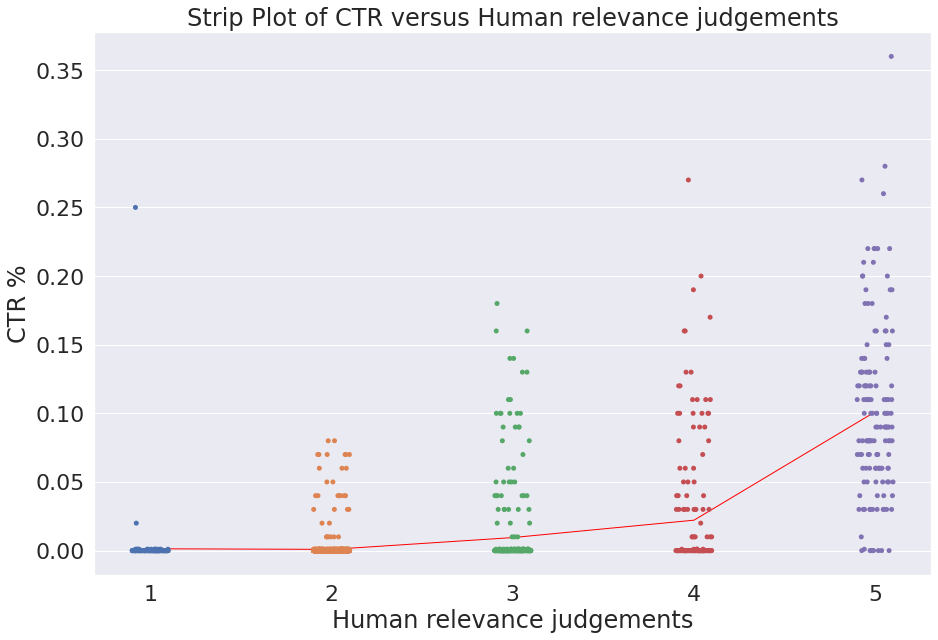

In [16]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set(font_scale=2)
fig, ax, = plt.subplots()

# need to subtract 1 for lineplot to use same range as stripplot
# https://stackoverflow.com/questions/53986627/stripplot-and-lineplot-weird-result
x2 = (exim['HUMAN']-1)

sns_plot = sns.stripplot(x = 'HUMAN', y = 'CTR-6', data = exim, ax =ax).set(title='Strip Plot of CTR versus Human relevance judgements',xlabel='Human relevance judgements',ylabel='CTR %')
sns_plot = sns.lineplot(x = x2, y = 'CTR-6', data = exim, ax=ax, color='red', linewidth=1, ci=None)



In [17]:
# save file
sns_plot.figure.savefig("/kaggle/working/strip-plot-with-line.png")
#!ls -lrt /kaggle/working


[Text(0.5, 1.0, 'Box Plot of CTR versus Human relevance judgements'),
 Text(0.5, 0, 'Human relevance judgements'),
 Text(0, 0.5, 'CTR %')]

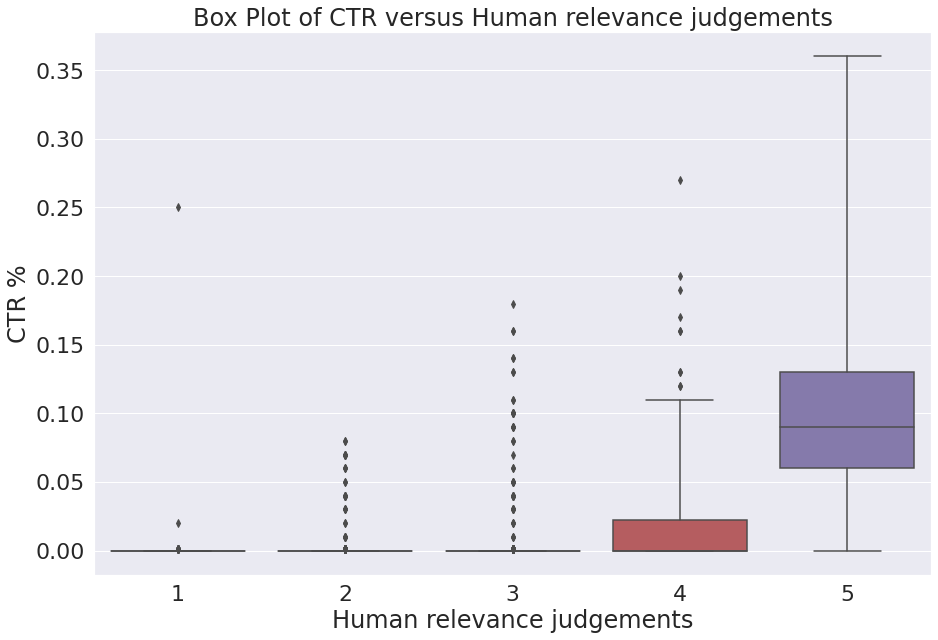

In [18]:
sns.boxplot(x = 'HUMAN', y = 'CTR-6', data = exim, whis=4).set(title='Box Plot of CTR versus Human relevance judgements',xlabel='Human relevance judgements',ylabel='CTR %')


In [19]:
!pip3 install scipy

In [20]:
from scipy.stats import ttest_rel

In [21]:
#exim.rename(columns={'HUMAN':'','CTR-6:''})

# **Interpreting the Correlation Coefficient**  <a class="anchor"  id="Interpreting"></a>
If we wish to label the strength of the association, for absolute values of r, Evans (1996) suggest the following (arbitrary) thresholds can be applied; -
* 0-0.19 is regarded as very weak, 
* 0.2-0.39 as weak, 
* 0.40-0.59 as moderate, 
* 0.6-0.79 as strong and 
* 0.8-1 as very strong correlation


# **Person versus Spearman**  <a class="anchor"  id="Pearson"></a>
Pearson coefficient measures linear trend, 
Spearman coeffiecient measures monotonic trend

In [22]:

# calculate the Pearson's correlation between two variables
from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr
from scipy.stats import spearmanr
# seed random number generator
seed(1)
# prepare data

In [23]:
data1 = exim['HUMAN']
data2 = exim['CTR-6']

data1 = data1.dropna()
data2 = data2.dropna()

# calculate Pearson's correlation
corr, _ = pearsonr(data1, data2)
print('Pearson\'s correlation:  human v click-through-rate: %.3f' % corr)

Pearson's correlation:  human v click-through-rate: 0.586


In [24]:
data1 = exim['HUMAN']
data2 = exim['CTR-6']

data1 = data1.dropna()
data2 = data2.dropna()

from scipy.stats import spearmanr
corr, _ = spearmanr(data1, data2)
print('Spearman\'s correlation:  human v click-through-rate: %.3f' % corr)

Spearman's correlation:  human v click-through-rate: 0.437


In [25]:
# calculate spearman's correlation
coef, p = spearmanr(data1, data2)
print('Spearmans correlation coefficient: %.3f' % coef)
print ('p-value',p)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.437
p-value 1.6350135746535322e-119
Samples are correlated (reject H0) p=0.000


# **Statistical Power**  <a class="anchor"  id="Power"></a>

In [26]:
from statsmodels.stats.power import TTestIndPower

# Parameters
effect_size = 0.5  # Cohen's d
alpha = 0.05       # Significance level
power = 0.8        # Desired power

# Initialize power analysis
analysis = TTestIndPower()

# Calculate required sample size
sample_size = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')
print(f"Required sample size: {sample_size}")

Required sample size: 63.765611775409525
